In [6]:
import torch
import deepxde as dde
import numpy as np
from typing import cast, Any

%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [7]:
# set seed for reproducibility
# seed = 1234
# dde.config.set_random_seed(seed)

In [21]:
class HarmonicOscillator0D:
    """Class modeling the harmonic oscillator in 0+1 dimensions. The ODE is:
    $$
        \\frac{\\partial^2 y}{\\partial t^2} + \\xi_0 * \\omega_0 * \\frac{\\partial y}{\\partial t} + \\frac{\\omega_0^2}{4} y = 0
    $$
    and with initial conditions $y(t = 0) = y_0, y^\\prime(t = 0) = y_1$.


    Args:
        omega0 (float): Intrinsic frequency of the system.
        xi0 (float): Fluid friction term.
        y0 (float): Initial value of the solution.
        y1 (float): Initial derivative of the solution.
    """

    __slots__ = ("xi0", "omega0", "xi", "omega", "y0", "y1")

    def __init__(self, xi0: float, omega0: float, y0: float, y1: float):
        # ODE parameters
        self.xi0 = xi0
        self.omega0 = omega0
        self.xi = xi0 * omega0 / 2
        self.omega = self.omega0 * np.sqrt(np.abs(np.power(self.xi0, 2) - 1)) / 2

        # Initial value condition
        self.y0 = y0
        self.y1 = y1

        # Define the geometry

    def equation(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        dy_dt = cast(torch.Tensor, dde.grad.jacobian(y, x, i=0, j=0))
        dy2_dt2 = cast(torch.Tensor, dde.grad.hessian(y, x, i=0, j=0))
        ode = dy2_dt2 + self.xi0 * self.omega0 * dy_dt + (self.omega0**2 / 4) * y
        return ode

    def initial_value(self, x: torch.Tensor) -> torch.Tensor:
        return y0

    def initial_value_derivative(
        self, x: torch.Tensor, y: torch.Tensor, X: Any
    ) -> torch.Tensor:
        dy_dt = cast(torch.Tensor, dde.grad.jacobian(y, x, i=0, j=0))
        return dy_dt - self.y1

    def exact_solution(self, x: np.ndarray) -> torch.Tensor:
        # Damping term
        exp_term = np.exp(-self.xi * x)
        # Critical solution
        if self.xi0 == 1:
            c0 = self.y0
            c1 = self.y1 + self.xi * self.y0
            return exp_term * (c0 + c1 * x)
        else:
            c0 = self.y0
            c1 = (self.y1 + self.xi * self.y0) / self.omega
            # Underdamped case
            if self.xi0 < 1:
                return exp_term * (
                    c0 * np.cos(self.omega * x) + c1 * np.sin(self.omega * x)
                )
            # Overdamped case
            else:
                return exp_term * (
                    c0 * np.cosh(self.omega * x) + c1 * np.sinh(self.omega * x)
                )

In [45]:
# Equation parameters

omega0 = 2 * np.pi * 5
y0 = 1
y1 = 0

# Neural network parameters
input_size = [1]
output_size = [1]
layers_sizes = input_size + [64, 128, 64] + output_size
activation = "tanh"
initializer = "Glorot normal"

# Training parameters
optimizer_kw = dict(
    lr=0.001,
    metrics=["l2 relative error"],
    loss_weights=[0.001, 1, 1],
)
n_iterations = 10_000

# Mesh parameters
n_training_inside = 64
n_training_bdy = 2
n_training_initial = 2
n_test = 500


def solve_problem(xi0: float, omega0: float, y0: float, y1: float) -> None:

    # System
    ho = HarmonicOscillator0D(xi0=xi0, omega0=omega0, y0=y0, y1=y1)

    # Geometry description
    geom = dde.geometry.TimeDomain(0, 1)

    def boundary_t0(x: torch.Tensor, on_boundary: bool) -> bool:
        return on_boundary and dde.utils.isclose(x[0], 0)

    # Initial value conditions
    ic_value = dde.icbc.IC(geom, ho.initial_value, lambda _, on_initial: on_initial)
    ic_derivative_value = dde.icbc.OperatorBC(
        geom, ho.initial_value_derivative, boundary_t0
    )

    # Load data
    data = dde.data.TimePDE(
        geom,
        ho.equation,
        [ic_value, ic_derivative_value],
        num_domain=n_training_inside,
        num_boundary=n_training_bdy,
        # num_initial=n_training_initial,
        solution=ho.exact_solution,
        num_test=n_test,
    )

    neural_net = dde.nn.FNN(layers_sizes, activation, initializer)
    model = dde.Model(data, neural_net)
    model.compile("adam", **optimizer_kw)

    losshistory, train_state = model.train(iterations=n_iterations)
    return losshistory, train_state

Compiling model...
'compile' took 0.000441 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [9.86e-02, 1.00e+00, 5.57e-03]    [9.95e-02, 1.00e+00, 5.57e-03]    [1.01e+00]    
1000      [8.61e-02, 7.17e-01, 2.77e-03]    [6.86e-02, 7.17e-01, 2.77e-03]    [9.57e-01]    
2000      [1.95e-01, 3.61e-01, 6.56e-03]    [1.87e-01, 3.61e-01, 6.56e-03]    [8.40e-01]    
3000      [1.66e-01, 2.73e-01, 3.26e-05]    [1.63e-01, 2.73e-01, 3.26e-05]    [7.76e-01]    
4000      [1.07e-01, 3.35e-02, 7.33e-08]    [1.11e-01, 3.35e-02, 7.34e-08]    [4.34e-01]    
5000      [1.47e-01, 1.32e-02, 1.21e-01]    [1.52e-01, 1.32e-02, 1.21e-01]    [2.78e-01]    
6000      [5.09e-02, 4.88e-03, 7.32e-05]    [5.04e-02, 4.88e-03, 7.32e-05]    [2.08e-01]    
7000      [4.61e-02, 3.82e-03, 4.45e-07]    [4.54e-02, 3.82e-03, 4.45e-07]    [1.90e-01]    
8000      [3.23e-02, 2.76e-03, 1.39e-02]    [3.06e-02, 2.76e-03, 1.39e-02]    [1.39e-01]    
9000 

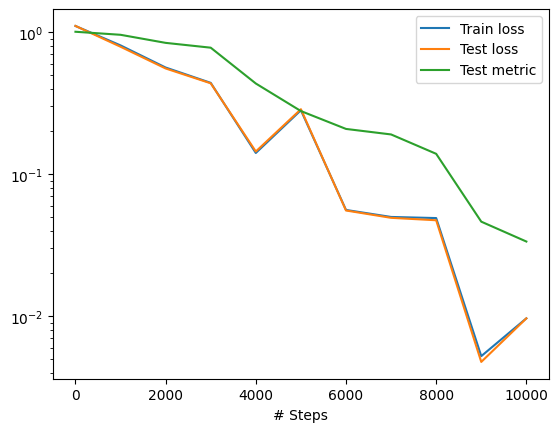

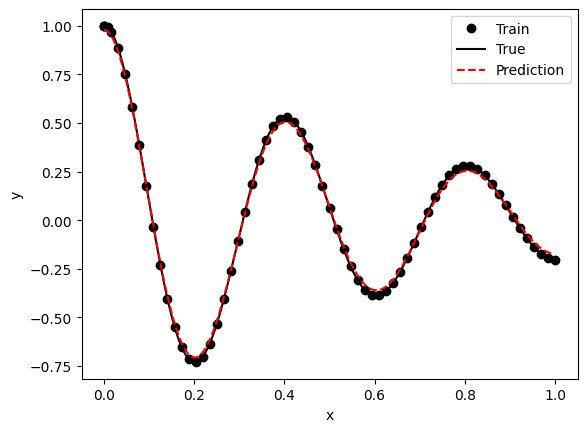

In [46]:
loss_history, train_state = solve_problem(xi0=0.1, omega0=omega0, y0=y0, y1=y1)
dde.saveplot(loss_history, train_state, issave=False, isplot=True)